# Convert BUP20 Annotation to YOLOv8 Format

----------------------------------

Delete `datasets/bup20-seg` before running the cells below.

In [1]:
DATASET_PATH = "/otherssd/bag/CKA_sweet_pepper_2020_summer"
NUM_VAL_SAMPLES = 12

-------------------------------------

In [13]:
import json
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import numpy as np
import os

def remove_prefix(text, prefix):
    if text.startswith(prefix):
        return text[len(prefix):]
    return text  # or whatever

from json2yolo import *
def convert_coco_json(json_dir='../coco/annotations/', use_segments=False, cls91to80=False):
    save_dir = make_dirs()  # output directory
    coco80 = coco91_to_coco80_class()

    # Import json
    for json_file in sorted(Path(json_dir).resolve().glob('*.json')):
        fn = Path(save_dir) / 'labels' / json_file.stem.replace('instances_', '')  # folder name
        fn.mkdir()
        with open(json_file) as f:
            data = json.load(f)

        # Create image dict
        images = {'%g' % x['id']: x for x in data['images']}
        # Create image-annotations dict
        imgToAnns = defaultdict(list)
        for ann in data['annotations']:
            imgToAnns[ann['image_id']].append(ann)

        # Write labels file
        for img_id, anns in tqdm(imgToAnns.items(), desc=f'Annotations {json_file}'):
            img = images['%g' % img_id]
            h, w, f = img['height'], img['width'], img['file_name']

            bboxes = []
            segments = []
            for ann in anns:
                if ann['iscrowd']:
                    continue
                # The COCO box format is [top left x, top left y, width, height]
                box = np.array(ann['bbox'], dtype=np.float64)
                box[:2] += box[2:] / 2  # xy top-left corner to center
                box[[0, 2]] /= w  # normalize x
                box[[1, 3]] /= h  # normalize y
                if box[2] <= 0 or box[3] <= 0:  # if w <= 0 and h <= 0
                    continue

                cls = coco80[ann['category_id'] - 1] if cls91to80 else ann['category_id'] - 1  # class
                cls = 49 # <------------------------------------------------------------------------------ SET ALL LABELS TO "ORANGE"
                box = [cls] + box.tolist()
                if box not in bboxes:
                    bboxes.append(box)
                # Segments
                if use_segments:
                    if len(ann['segmentation']) > 1:
                        s = merge_multi_segment(ann['segmentation'])
                        s = (np.concatenate(s, axis=0) / np.array([w, h])).reshape(-1).tolist()
                    else:
                        s = [j for i in ann['segmentation'] for j in i]  # all segments concatenated
                        s = (np.array(s).reshape(-1, 2) / np.array([w, h])).reshape(-1).tolist()
                    s = [cls] + s
                    if s not in segments:
                        segments.append(s)

            # Write
            with open((fn / f).with_suffix('.txt'), 'a') as file:
                for i in range(len(bboxes)):
                    line = *(segments[i] if use_segments else bboxes[i]),  # cls, box or segments
                    file.write(('%g ' * len(line)).rstrip() % line + '\n')

In [3]:
with open(DATASET_PATH + "/CKA_sweet_pepper_2020_summer.json", 'r') as f:
  metadata = json.load(f)

m_images = metadata["images"]
m_categories = metadata["categories"]
m_annotations = metadata["annotations"]

#############################################

new_metadata = {}
img_id_to_file_name = {}

for image in m_images:
    if image["file_name"] not in new_metadata:
      m = {}
      m["id"] = image["id"]
      m["width"] = image["width"]
      m["height"] = image["height"]
      m["num_annotations"] = image["num_annotations"]
      m["path"] = remove_prefix(image["path"], '/datasets/CKA_sweet_pepper_2020_summer/')
      m["annotations"] = []
      new_metadata[ image["file_name"] ] = m
      img_id_to_file_name[image["id"]] = image["file_name"]
    else:
       print("DUPLICATE!")

#############################################

for annotation in m_annotations:
    del annotation["events"]
    del annotation["milliseconds"]
    del annotation["metadata"]
    del annotation["creator"]

    file_name = img_id_to_file_name[ annotation["image_id"] ]
    new_metadata[file_name]["annotations"].append(annotation)

#############################################

for file_name, sample in new_metadata.items():
    reported_num_annotations = sample["num_annotations"]
    real_num_annotations = len(sample["annotations"])
    if reported_num_annotations != real_num_annotations:
        print("There is an annotation problem with", file_name)
        print("Reported/Real annotations:", reported_num_annotations, "/", real_num_annotations)
        if real_num_annotations>0 and reported_num_annotations==0:
          print("FIX: Set reported number of annotations to", real_num_annotations)
          sample["num_annotations"] = real_num_annotations

There is an annotation problem with 1600937799615509.tiff
Reported/Real annotations: 0 / 29
FIX: Set reported number of annotations to 29
There is an annotation problem with 1600937806548208.tiff
Reported/Real annotations: 0 / 26
FIX: Set reported number of annotations to 26


In [4]:
convert_coco_json(json_dir=DATASET_PATH, use_segments=True)

Annotations /otherssd/bag/CKA_sweet_pepper_2020_summer/CKA_sweet_pepper_2020_summer.json: 100%|██████████| 280/280 [00:03<00:00, 75.84it/s] 


In [5]:
!mv "new_dir" "bup20-seg"
!mv "bup20-seg/labels/CKA_sweet_pepper_2020_summer" "bup20-seg/labels/train"
!mkdir "bup20-seg/images/train"

In [6]:
import shutil

for file_name, sample in new_metadata.items():
    file_from = DATASET_PATH + "/" + sample["path"]
    file_to = "bup20-seg/images/train/" + file_name
    shutil.copyfile(file_from, file_to)

In [7]:
!mkdir -p datasets
!mv "bup20-seg" "datasets/bup20-seg"

In [12]:
!mkdir -p "datasets/bup20-seg/images/val"
!mkdir -p "datasets/bup20-seg/labels/val"

In [16]:
count = 0
for file_name, sample in new_metadata.items():
  image_file_name = file_name
  annotation_file_name = os.path.splitext(file_name)[0] + ".txt"
  print("Moving", image_file_name, annotation_file_name, "to the validation set.")

  file_src = "datasets/bup20-seg/images/train/" + image_file_name
  file_dst = "datasets/bup20-seg/images/val/" + image_file_name
  shutil.move(file_src, file_dst)

  file_src = "datasets/bup20-seg/labels/train/" + annotation_file_name
  file_dst = "datasets/bup20-seg/labels/val/" + annotation_file_name
  shutil.move(file_src, file_dst)

  count += 1
  if NUM_VAL_SAMPLES <= count:
    break

Moving 1600937303365508.tiff 1600937303365508.txt to the validation set.
Moving 1600937306498842.tiff 1600937306498842.txt to the validation set.
Moving 1600937308963483.tiff 1600937308963483.txt to the validation set.
Moving 1600937320232102.tiff 1600937320232102.txt to the validation set.
Moving 1600937323568975.tiff 1600937323568975.txt to the validation set.
Moving 1600937326169536.tiff 1600937326169536.txt to the validation set.
Moving 1600937329567112.tiff 1600937329567112.txt to the validation set.
Moving 1600937332431798.tiff 1600937332431798.txt to the validation set.
Moving 1600937334896723.tiff 1600937334896723.txt to the validation set.
Moving 1600937337894590.tiff 1600937337894590.txt to the validation set.
Moving 1600937341229933.tiff 1600937341229933.txt to the validation set.
Moving 1600937344429542.tiff 1600937344429542.txt to the validation set.


## Test COCO to YOLOV8 Conversion

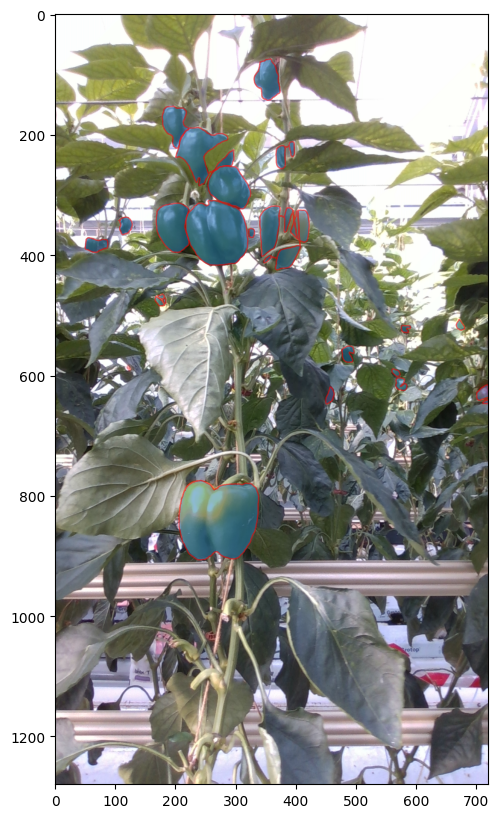

In [25]:
#sample_name = "1601540154129871"
#sample_name = "1601540400081271"
sample_name = "1601541642725148"

img_path = "datasets/bup20-seg/images/train/" + sample_name + ".tiff"
ann_path = "datasets/bup20-seg/labels/train/" + sample_name + ".txt"

image = plt.imread(img_path)

annotation_poly = []
annotation_label = []
with open(ann_path) as file:
    for line in file:
        annotation_label.append( int(line.split(" ")[0]) )
        y = np.array(line.split(" ")[1:]).astype(np.float32)
        annotation_poly.append(y)

fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(image)

height = image.shape[0]
width = image.shape[1]

image_shape = np.array([width, height]).reshape((-1,2))

for poly, label in zip(annotation_poly, annotation_label):
    p = Polygon(poly.reshape((-1,2)) * image_shape, edgecolor = 'r', fill = True, alpha=0.5)
    ax.add_patch(p)